### Top-view Generation

Manually compute the projection of ground plane to top-view. Using GPS Coordinates locate the part of the data you are working on and compute a homography to map the first frame of the video to the top-view/satellite image.

Use a reference object to scale the top-view

In [1]:
import matplotlib
# !pip install opencv-python
import matplotlib.pyplot as ajeeb
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy import linalg
from scipy.linalg import null_space
# !pip install imageio
import imageio

Taking first frame of video

In [2]:
def capture_first_frame(video_path, output_path):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not video_capture.isOpened():
        print("Error: Unable to open the video file.")
        return

    # Read the first frame
    ret, frame = video_capture.read()

    # Check if the frame is read successfully
    if not ret:
        print("Error: Unable to read the first frame.")
        return

    # Save the first frame to the specified output path
    cv2.imwrite(output_path, frame)

    # Release the video capture object
    video_capture.release()

    print("First frame captured and saved successfully.")


In [3]:
# Specify the path to the video file
video_path = 'vid3.mp4'

# Specify the output path for saving the first frame
output_path = 'frame1.jpg'

# Call the function to capture the first frame
capture_first_frame(video_path, output_path)

First frame captured and saved successfully.


Pre-processing image

In [5]:
original_coords = (31.4205759,74.2369952)

In [19]:

img1 = cv2.imread('frame1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('sat_img.png', cv2.IMREAD_GRAYSCALE)
print(img1.shape)
print(img2.shape)

img1 = cv2.resize(img1, (500, 500))
img2 = cv2.resize(img2, (500, 500))

print(img1.shape)
print(img2.shape)


(480, 852)
(567, 935)
(500, 500)
(500, 500)


Getting point correspondances

In [20]:
# Copy pasted my point reader function from the 24100092_PA3.py for simplicity
def point_reader(img):
    '''
    img - The image to be marked points on
    '''
    points = list()

    def click_event(event, x, y, flags, params):
        # checking for left mouse clicks
        if event == cv2.EVENT_LBUTTONDOWN:
            print(x, ' ', y)
            points.append((x,y))

        # checking for right mouse clicks
        if event==cv2.EVENT_RBUTTONDOWN:
            print(x, ' ', y)
            points.append((x,y))

    # Opening image and waiting till closed
    cv2.imshow('image',img)
    cv2.setMouseCallback('image', click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    print(points)
    points = np.array(points)
    print(points)

    return points


In [21]:
# Save your points in an np.array

print("Select at least 5 points from the image")
initial_points = point_reader(img1)

if len(initial_points) < 5:
    print("Please select at least 4 points")

Select at least 5 points from the image
102   397
490   377
200   235
329   238
234   179
275   179
[(102, 397), (490, 377), (200, 235), (329, 238), (234, 179), (275, 179)]
[[102 397]
 [490 377]
 [200 235]
 [329 238]
 [234 179]
 [275 179]]


In [22]:
# Save your points in an np.array

print("Select the same number of points from the second image. These points must be corresponding to the previously selected points")

final_points = point_reader(img2)

if len(initial_points) != len(final_points):
    print("Please select same number of points as first image")

Select the same number of points from the second image. These points must be corresponding to the previously selected points
100   115
97   125
115   110
116   123
158   110
159   124
[(100, 115), (97, 125), (115, 110), (116, 123), (158, 110), (159, 124)]
[[100 115]
 [ 97 125]
 [115 110]
 [116 123]
 [158 110]
 [159 124]]


In [23]:
# Function to get 2 rows of matrix given one point correspondance

def get_rows(initial, final):

    x = initial[0]
    y = initial[1]
    x2 = final[0]
    y2 = final[1]
    row1 = [x, y, 1, 0, 0, 0, -x2*x, -x2*y, -x2]
    row2 = [0, 0, 0, x, y, 1, -y2*x, -y2*y, -y2]

    return row1, row2

def make_matrix(old, new):
    if len(old) != len(new):
        return

    res = list()
    for i in range(len(old)):
        r1, r2 = get_rows(old[i],new[i])
        res.append(r1)
        res.append(r2)


    res = np.array(res)
    return res


In [24]:
my_mat = make_matrix(initial_points, final_points)

print(my_mat)
print(my_mat.shape)

[[   102    397      1      0      0      0 -10200 -39700   -100]
 [     0      0      0    102    397      1 -11730 -45655   -115]
 [   490    377      1      0      0      0 -47530 -36569    -97]
 [     0      0      0    490    377      1 -61250 -47125   -125]
 [   200    235      1      0      0      0 -23000 -27025   -115]
 [     0      0      0    200    235      1 -22000 -25850   -110]
 [   329    238      1      0      0      0 -38164 -27608   -116]
 [     0      0      0    329    238      1 -40467 -29274   -123]
 [   234    179      1      0      0      0 -36972 -28282   -158]
 [     0      0      0    234    179      1 -25740 -19690   -110]
 [   275    179      1      0      0      0 -43725 -28461   -159]
 [     0      0      0    275    179      1 -34100 -22196   -124]]
(12, 9)


In [25]:
# List of useful functions
u, s, vh = np.linalg.svd(my_mat) # Replace it with your H matrix
vh = np.transpose(vh)
P = vh[:,len(vh[0])-1]

P = np.array([P[0:3], P[3:6], P[6:9]])
print("Homography matrix\n",P)

Homography matrix
 [[ 2.01757062e-04 -4.20869928e-03  4.77395451e-01]
 [-1.62777446e-04 -5.56158816e-03  8.78635538e-01]
 [ 1.13287002e-06 -4.66608177e-05  6.66790264e-03]]


In [26]:
img1_warped = cv2.warpPerspective(img1, np.linalg.inv(P), (500, 500))
img1_warped2 = cv2.warpPerspective(img1, P, (500, 500))

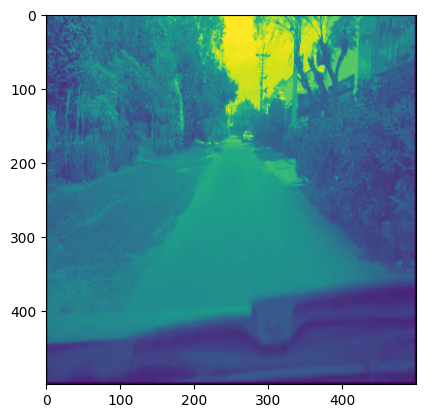

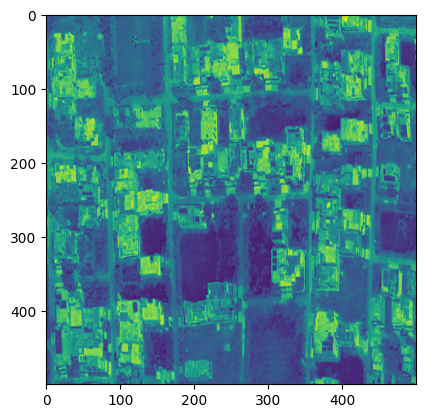

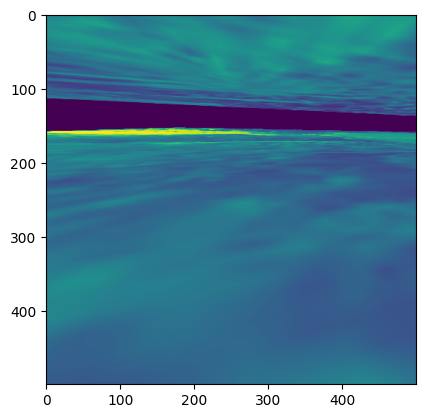

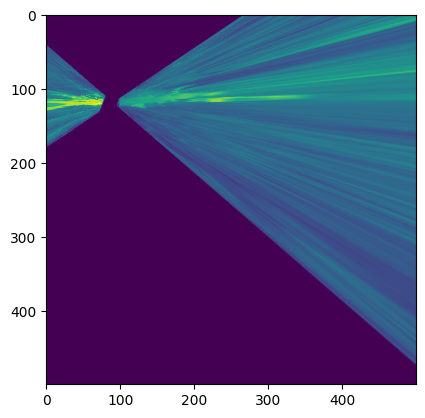

In [27]:
plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()


plt.imshow(img1_warped)
plt.show()

plt.imshow(img1_warped2)
plt.show()